In [1]:
# !pip install evaluate

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from tqdm import tqdm
import evaluate
import matplotlib.pyplot as plt

# Check Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Configuration ---
# Update these paths to match your Google Drive or local environment
BASE_DIR =  "/content/drive/MyDrive/CropAndWeed_Final"
IMG_DIR = os.path.join(BASE_DIR, "images")
MASK_DIR = os.path.join(BASE_DIR, "labelIds", "CropOrWeed2")
MODEL_CHECKPOINT = "nvidia/segformer-b2-finetuned-ade-512-512"

# Validation
if not os.path.exists(IMG_DIR) or not os.path.exists(MASK_DIR):
    print("WARNING: Directories not found. Please check paths in Block 1.")

Using device: cuda


In [ ]:
class ExG_Attention(nn.Module):
    def __init__(self):
        super().__init__()
        # No learnable parameters needed for the pure math formula yet.

    def forward(self, images):
        # Input images shape: (Batch_Size, 3, Height, Width)
        # We assume pixel values are normalized roughly to [0, 1] or [0, 255]

        # 1. Split the channels (Red, Green, Blue)
        r = images[:, 0, :, :]
        g = images[:, 1, :, :]
        b = images[:, 2, :, :]

        # 2. Calculate Excess Green Index
        # Formula: ExG = 2*G - R - B
        exg_raw = (2 * g) - r - b

        # 3. Create the Attention Mask (Squash to 0-1 range)
        # We use Sigmoid because we want a probability-like mask.
        attention_mask = torch.sigmoid(exg_raw)

        # 4. Restore Channel Dimension
        # The math reduced shape to (Batch, H, W).
        # We need (Batch, 1, H, W) to multiply with other features later.
        attention_mask = attention_mask.unsqueeze(1)

        return attention_mask

In [ ]:
# --- 2. NEW: Parallel Detail Decoder (Replaces DetailPreservingDecoder) ---
class ParallelDetailDecoder(nn.Module):
    """
    Architecture:
    1. Projects all Encoder stages (1-4) to a common embedding dimension.
    2. Upsamples them all to the size of Stage 1.
    3. Concatenates them into one massive tensor (The "Bucket").
    4. Fuses them using a single Conv2D layer (Enables RDD Pruning).
    5. Adds the Stage 1 features back to the result (Residual Connection) to force edge details.
    """
    def __init__(self, encoder_channels, num_classes, embedding_dim=256):
        super().__init__()

        # 1. Lateral Layers (1x1 Convolutions)
        # Projects [64, 128, 320, 512] -> [256, 256, 256, 256]
        self.lateral_convs = nn.ModuleList()
        for channels in encoder_channels:
            self.lateral_convs.append(
                nn.Conv2d(channels, embedding_dim, kernel_size=1)
            )

        # 2. The Big Fusion Layer (Equivalent to Conv2DFuse)
        # Input: embedding_dim * 4 (because we concat 4 stages)
        # Output: embedding_dim
        # This is the layer we will "slice" later for RDD.
        self.linear_fuse = nn.Sequential(
            nn.Conv2d(in_channels=embedding_dim * 4, out_channels=embedding_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(embedding_dim),
            nn.ReLU()
        )

        # 3. Final Prediction Head
        self.prediction_head = nn.Conv2d(embedding_dim, num_classes, kernel_size=1)

    def forward(self, features):
        # features = [c1, c2, c3, c4]

        # A. Project all stages
        projected = [layer(f) for layer, f in zip(self.lateral_convs, features)]

        # B. Upsample everything to match Stage 1 (High Res)
        # c1 is usually 1/4th of image size
        target_size = projected[0].shape[-2:]
        upsampled_features = []
        for p in projected:
            upsampled_features.append(
                F.interpolate(p, size=target_size, mode='bilinear', align_corners=False)
            )

        # C. FUSE ALL (The "Bucket")
        # Concatenate along channel dimension
        concatenated = torch.cat(upsampled_features, dim=1)

        # D. Apply Fusion
        fused = self.linear_fuse(concatenated)

        # E. RESIDUAL DETAIL INJECTION
        # We explicitly ADD Stage 1 features back to the fused result.
        # This ensures high-frequency details (edges) are not lost in the fusion.
        fused = fused + projected[0]

        # F. Predict
        logits = self.prediction_head(fused)

        return logits

In [ ]:
# --- 3. Research Grade Wrapper (Updated) ---
class SegFormer_Research_Grade(nn.Module):
    def __init__(self, pretrained_model_name, num_classes):
        super().__init__()

        # A. Load Backbone
        self.base_model = SegformerForSemanticSegmentation.from_pretrained(
            pretrained_model_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

        # B. Config
        encoder_channels = self.base_model.config.hidden_sizes

        # C. Biological Prior
        self.exg_module = ExG_Attention()

        # D. NEW: Use Parallel Decoder
        self.custom_decoder = ParallelDetailDecoder(
            encoder_channels=encoder_channels,
            num_classes=num_classes
        )

    def forward(self, pixel_values, labels=None):
        # 1. ExG Attention
        exg_mask = self.exg_module(pixel_values)

        # 2. Encoder Forward Pass
        outputs = self.base_model.segformer(
            pixel_values,
            output_hidden_states=True
        )
        all_hidden_states = outputs.hidden_states

        # 3. Feature Gating (ExG Intervention on Deepest Feature)
        last_feature_map = all_hidden_states[-1]
        mask_resized = F.interpolate(exg_mask, size=last_feature_map.shape[-2:], mode='nearest')
        refined_last_feature = last_feature_map * mask_resized

        # Update feature list
        features_for_decoder = list(all_hidden_states)
        features_for_decoder[-1] = refined_last_feature

        # Note: SegFormer returns [Input_Embed, S1, S2, S3, S4]
        # We usually want just the stages [S1, S2, S3, S4]
        # The 'all_hidden_states' usually includes the initial embeddings at index 0.
        # However, HuggingFace implementation varies slightly by version.
        # Ideally, we pass the last 4 elements.
        encoder_features = features_for_decoder[-4:]

        # 4. Custom Parallel Decoding
        logits = self.custom_decoder(encoder_features)

        # 5. Final Resize (to original image size)
        upsampled_logits = F.interpolate(
            logits,
            size=pixel_values.shape[-2:],
            mode='bilinear',
            align_corners=False
        )

        # 6. Loss
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=255)
            loss = loss_fct(upsampled_logits, labels)

        return (loss, upsampled_logits) if loss is not None else upsampled_logits

In [ ]:
class CropWeedDataset(Dataset):
    def __init__(self, img_dir, mask_dir, processor):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.processor = processor

        # 1. Identify all valid pairs
        mask_files = set(f for f in os.listdir(mask_dir) if f.endswith('.png'))
        img_files = set(f for f in os.listdir(img_dir) if f.endswith('.jpg'))

        # Find intersection
        self.valid_files = []
        for m_file in mask_files:
            i_file = m_file.replace(".png", ".jpg")
            if i_file in img_files:
                self.valid_files.append((i_file, m_file))

        self.valid_files.sort()
        print(f"Dataset Initialized. Found {len(self.valid_files)} valid image/mask pairs.")

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        img_name, mask_name = self.valid_files[idx]

        # Load File
        image = Image.open(os.path.join(self.img_dir, img_name)).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, mask_name))

        # Process (Resize, Normalize, Convert to Tensor)
        encoding = self.processor(
            images=image,
            segmentation_maps=mask,
            return_tensors="pt"
        )

        pixel_values = encoding.pixel_values.squeeze()
        labels = encoding.labels.squeeze()

        return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
# 1. Define Processor
processor = SegformerImageProcessor.from_pretrained(MODEL_CHECKPOINT)

# 2. Instantiate Full Dataset
try:
    full_dataset = CropWeedDataset(IMG_DIR, MASK_DIR, processor)

    # 3. Split Train/Val (90% / 10%)
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    print(f" > Training Samples:   {len(train_dataset)}")
    print(f" > Validation Samples: {len(val_dataset)}")

    # 4. Create Loaders
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

except FileNotFoundError:
    print("Skipping Dataset creation (files not found). Ensure paths are correct.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


Dataset Initialized. Found 7705 valid image/mask pairs.
 > Training Samples:   6934
 > Validation Samples: 771


In [ ]:
# --- 1. Define ID Mappings ---
id2label = {0: "Crop", 1: "Weed", 2: "Soil"}
label2id = {v: k for k, v in id2label.items()}

# --- 2. Load the Custom Research Grade Model ---
# INTEGRATION STEP: We use the custom class defined in Block 4
print("Initializing SegFormer Research Grade (ExG + Custom Decoder)...")
model = SegFormer_Research_Grade(
    pretrained_model_name=MODEL_CHECKPOINT,
    num_classes=3
)
model.to(device)

# --- 3. Optimizer ---
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
print("Model and Optimizer prepared.")

Initializing SegFormer Research Grade (ExG + Custom Decoder)...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/110M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

Model and Optimizer prepared.


In [ ]:
#Loading the modified model
folder_name =  "/content/drive/MyDrive/model_v4.0_seg"
filename = "custom_model_best.pth"
weights_path = os.path.join(folder_name, filename)

print(f"Targeting weights at: {weights_path}")

# --- 2. Initialize the Architecture ---
# We build the empty 'Research Grade' skeleton first
model_v2 = SegFormer_Research_Grade(
    pretrained_model_name="nvidia/segformer-b2-finetuned-ade-512-512",
    num_classes=3
)

# --- 3. Load the Weights ---
if os.path.exists(weights_path):
    # Load weights to CPU first to avoid memory errors, then move to GPU
    state_dict = torch.load(weights_path, map_location=device)
    model_v2.load_state_dict(state_dict)

    # Move to GPU
    model_v2.to(device)
    model_v2.eval()
    print("SUCCESS: Model V2 loaded and ready.")

Targeting weights at: /content/drive/MyDrive/model_v4.0_seg/custom_model_best.pth


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([3, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SUCCESS: Model V2 loaded and ready.


In [ ]:
# 1. Inspect the Encoder Structure
# We must access 'base_model' first, then 'segformer', then 'encoder'
encoder_ref = model_v2.base_model.segformer.encoder

print("Model Architecture: SegFormer B2 (Inside Custom Wrapper)")
print("-" * 40)
print(f"Number of Stages in Encoder: {len(encoder_ref.block)}")
print("-" * 40)

# 2. Count blocks per stage
total_blocks = 0
stage_config = []

# Iterate through the encoder blocks found in the corrected path
for i, stage in enumerate(encoder_ref.block):
    num_blocks = len(stage)
    stage_config.append(num_blocks)
    total_blocks += num_blocks

    print(f"Stage {i+1}: contains {num_blocks} Transformer Blocks")

    # Optional: Peek at the first block structure
    if i == 0:
        # Just printing the type to keep output clean,
        # or remove .__class__ to see full layer details
        print(f"   -> Block Type: {stage[0].__class__.__name__}")

print("-" * 40)
print(f"Total Skippable Blocks: {total_blocks}")
print(f"Configuration: {stage_config}")

Model Architecture: SegFormer B2 (Inside Custom Wrapper)
----------------------------------------
Number of Stages in Encoder: 4
----------------------------------------
Stage 1: contains 3 Transformer Blocks
   -> Block Type: SegformerLayer
Stage 2: contains 4 Transformer Blocks
Stage 3: contains 6 Transformer Blocks
Stage 4: contains 3 Transformer Blocks
----------------------------------------
Total Skippable Blocks: 16
Configuration: [3, 4, 6, 3]


In [ ]:
import torch
import torch.nn as nn

# --- 1. Define the Encoder Wrapper ---
class DynamicBlockWrapper(nn.Module):
    """
    Wraps a SegFormer encoder block to allow skipping it entirely.
    """
    def __init__(self, original_block):
        super().__init__()
        self.block = original_block
        self.skip = False

    def forward(self, hidden_states, height, width, output_attentions=False):
        # If skip is True, we bypass the heavy computation
        if self.skip:
            return (hidden_states,)
        return self.block(hidden_states, height, width, output_attentions)

# --- 2. Inject and Collect Wrappers ---
def inject_encoder_wrappers(model_instance):
    encoder = model_instance.base_model.segformer.encoder
    wrappers = []

    # Iterate over all 4 stages
    for stage_idx, stage in enumerate(encoder.block):
        for block_idx in range(len(stage)):
            # Grab the block
            original = stage[block_idx]

            # If it's not already wrapped, wrap it
            if not isinstance(original, DynamicBlockWrapper):
                wrapper = DynamicBlockWrapper(original)
                stage[block_idx] = wrapper
                wrappers.append(wrapper)
            else:
                # If already wrapped (e.g. ran cell twice), just grab it
                wrappers.append(original)

    return wrappers

# --- 3. Create the 'encoder_wrappers' Variable ---
print("Injecting Encoder Wrappers...")
# This creates the variable 'encoder_wrappers' that your config function needs
encoder_wrappers = inject_encoder_wrappers(model_v2)

print(f"Success. 'encoder_wrappers' is defined. It controls {len(encoder_wrappers)} blocks.")

Injecting Encoder Wrappers...
Success. 'encoder_wrappers' is defined. It controls 16 blocks.


In [ ]:
# --- Updated Wrapper: Strict Pruning ---
class DynamicFusionWrapper(nn.Module):
    def __init__(self, original_module):
        super().__init__()
        self.conv = original_module[0]
        self.bn = original_module[1]
        self.relu = original_module[2]

        self.weight = self.conv.weight
        self.bias = self.conv.bias

        # Initialize to the physical max (1024)
        self.active_in_channels = self.conv.in_channels

        self.stride = self.conv.stride
        self.padding = self.conv.padding
        self.dilation = self.conv.dilation
        self.groups = self.conv.groups

    def forward(self, x):
        # STRICT PRUNING: We manually slice the input 'x'
        # based on 'active_in_channels', ignoring the extra channels.

        # 1. Slice Input
        x = x[:, :self.active_in_channels, :, :]

        # 2. Slice Weights
        sliced_weight = self.weight[:, :self.active_in_channels, :, :]

        # 3. Conv
        x = F.conv2d(
            input=x,
            weight=sliced_weight,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            groups=self.groups
        )

        # 4. BN + ReLU
        x = self.bn(x)
        x = self.relu(x)

        return x

In [ ]:
import time
import torch
import evaluate
# CHANGE: Use notebook version to keep progress bar on one line
from tqdm.notebook import tqdm

# --- 1. Define the Benchmark Function (50 Samples Version) ---
def benchmark_rdd_config(model, wrappers, dataloader, config_name, num_batches=50):
    """
    Applies a config, measures FPS, and calculates mIoU on a SUBSET (num_batches).
    """
    # 1. Apply the Configuration
    apply_rdd_config(model, wrappers, config_name)

    # 2. Setup Metrics
    metric = evaluate.load("mean_iou")
    device = next(model.parameters()).device
    model.eval()

    # 3. Warmup (Run 5 batches)
    print(f" > Warming up for {config_name}...")
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= 5: break
            _ = model(pixel_values=batch["pixel_values"].to(device))

    # 4. Benchmarking Loop (Limited to num_batches)
    print(f" > Benchmarking {config_name} (Limit: {num_batches} batches)...")
    start_time = time.time()
    batch_count = 0

    # TQDM wrapper: total=num_batches ensures the bar shows 100% correctly at 50
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, total=num_batches, desc=f"Eval {config_name}")):
            # BREAK CONDITION: Stop after 50 batches
            if i >= num_batches:
                break

            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Inference
            logits = model(pixel_values=pixel_values)

            if isinstance(logits, tuple):
                logits = logits[1]

            if logits.shape[-2:] != labels.shape[-2:]:
                logits = torch.nn.functional.interpolate(
                    logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
                )

            predictions = logits.argmax(dim=1)
            metric.add_batch(predictions=predictions, references=labels)
            batch_count += 1

    end_time = time.time()

    # 5. Calculate Stats
    total_time = end_time - start_time
    total_images = batch_count * dataloader.batch_size
    fps = total_images / total_time

    # Compute mIoU
    metrics = metric.compute(num_labels=3, ignore_index=255, reduce_labels=False)
    miou = metrics["mean_iou"]

    return {
        "config": config_name,
        "mIoU": miou,
        "fps": fps
    }

In [ ]:
configs_to_test = ["B2_Full", "B2_a", "B2_b", "B2_c", "B2_d", "B2_e", "B2_f"]

experiment_results_full = []

print(f"Starting Full RDD Profile on {device}...")
print(f"Testing Configs: {configs_to_test}")
print("-" * 60)

# --- 3. The Experiment Loop ---
for config in configs_to_test:
    # Run the benchmark on the FULL validation loader
    result = benchmark_rdd_config(
        model=model_v2,
        wrappers=encoder_wrappers,
        dataloader=val_dataloader,
        config_name=config,
        num_batches=50 # Adjust if your validation set is smaller
    )

    experiment_results_full.append(result)
    # We print the result AFTER the progress bar finishes
    print(f" > Result: mIoU={result['mIoU']:.4f} | FPS={result['fps']:.1f}")

# --- 4. Summary Report ---
print("\n" + "="*60)
print("FINAL PAPER REPRODUCTION SUMMARY (Table III - Crop/Weed)")
print("="*60)
print(f"{'Config':<10} | {'mIoU':<8} | {'FPS':<8} | {'Rel Speed':<8}")
print("-" * 60)

baseline_fps = experiment_results_full[0]['fps']

for res in experiment_results_full:
    rel_speed = res['fps'] / baseline_fps
    print(f"{res['config']:<10} | {res['mIoU']:.4f}   | {res['fps']:.1f}     | {rel_speed:.2f}x")
print("="*60)

In [ ]:
###################################################### New Changes ##############################################################33

In [ ]:
# --- RDD Configuration (Table III from Paper) ---
# Format: {
#    "mask": [List of 16 booleans for Encoder Blocks],
#    "channels": [Int for Conv2DFuse Input Channels]
# }

# Helper to create masks.
# 0 = Run, 1 = Skip.
# B2 Original Structure: [3, 4, 6, 3] blocks per stage.

FULL_MASK = [0]*16 # All 16 blocks active

RDD_CONFIGS_NEW = {
    # 1. B2_Full: Max Power (1024 ch)
    "B2_Full": {
        "mask": FULL_MASK,
        "channels": 1024
    },

    # 2. B2_a: Minor trim (980 ch)
    "B2_a": {
        "mask": [0,0,1] + [0]*13,
        "channels": 980
    },

    # 3. B2_b: Moderate trim (940 ch)
    "B2_b": {
        "mask": [0,0,1] + [0]*13,
        "channels": 920
    },

    # 4. B2_c: Trim + Skip 1 Block (910 ch)
    "B2_c": {
        "mask": [0,0,1] + [0,0,0,1] + [0]*9,
        "channels": 900
    },

    # 5. B2_d: Trim + Skip 2 Blocks (880 ch)
    "B2_d": {
        "mask": [0,0,1] + [0,0,0,1] + [0,0,0,0,0,1] + [0]*3,
        "channels": 880
    },

    # 6. B2_e: Trim + Skip 3 Blocks (832 ch)
    "B2_e": {
        "mask": [0,0,1] + [0,0,0,1] + [0,0,0,0,0,1] + [0,0,1],
        "channels": 832
    },

     # 7. B2_f: The Floor (768 ch).
     # Retains Stage 3 context. Do not go lower.
    "B2_f": {
        "mask": [0,0,1] + [0,0,0,1] + [0,0,0,0,0,1] + [0,0,1],
        "channels": 768
    }
}

def apply_rdd_config(model_instance, model_wrappers, config_name):
    """
    Applies both the Encoder Block Skipping and the Decoder Channel Pruning.
    """
    if config_name not in RDD_CONFIGS_NEW:
        print(f"Error: Config {config_name} not found.")
        return

    cfg = RDD_CONFIGS_NEW[config_name]

    # 1. Apply Encoder Mask
    mask = cfg["mask"]
    active_blocks = 0
    for i, skip_val in enumerate(mask):
        # Set the .skip attribute on the wrappers list we created earlier
        model_wrappers[i].skip = bool(skip_val)
        if not skip_val: active_blocks += 1

    # 2. Apply Decoder Channel Pruning
    target_channels = cfg["channels"]

    # CHANGE: Updated path to 'custom_decoder'
    # We use the model_instance passed to the function
    model_instance.custom_decoder.linear_fuse.active_in_channels = target_channels

    print(f"--- Config Applied: {config_name} ---")
    print(f"  > Encoder: {active_blocks}/16 Blocks Active")
    print(f"  > Decoder: {target_channels} Channels Active")

# --- Verify Control ---
# We use 'model_v2' (your loaded model) and 'encoder_wrappers' (the list we created in the previous step)
print("Testing Configuration Switching...")
apply_rdd_config(model_v2, encoder_wrappers, "B2_Full")  # Should be 16 blocks, 980 channels
apply_rdd_config(model_v2, encoder_wrappers, "B2_a")  # Should be 13 blocks, 940 channels
apply_rdd_config(model_v2, encoder_wrappers, "B2_b")  # Should be 13 blocks, 940 channels
apply_rdd_config(model_v2, encoder_wrappers, "B2_c")  # Should be 13 blocks, 940 channels
apply_rdd_config(model_v2, encoder_wrappers, "B2_d")  # Should be 13 blocks, 940 channels
apply_rdd_config(model_v2, encoder_wrappers, "B2_e")  # Should be 13 blocks, 940 channels
apply_rdd_config(model_v2, encoder_wrappers, "B2_f")  # Should be 13 blocks, 940 channels

Testing Configuration Switching...
--- Config Applied: B2_Full ---
  > Encoder: 16/16 Blocks Active
  > Decoder: 1024 Channels Active
--- Config Applied: B2_a ---
  > Encoder: 15/16 Blocks Active
  > Decoder: 980 Channels Active
--- Config Applied: B2_b ---
  > Encoder: 15/16 Blocks Active
  > Decoder: 920 Channels Active
--- Config Applied: B2_c ---
  > Encoder: 14/16 Blocks Active
  > Decoder: 900 Channels Active
--- Config Applied: B2_d ---
  > Encoder: 13/16 Blocks Active
  > Decoder: 880 Channels Active
--- Config Applied: B2_e ---
  > Encoder: 12/16 Blocks Active
  > Decoder: 832 Channels Active
--- Config Applied: B2_f ---
  > Encoder: 12/16 Blocks Active
  > Decoder: 768 Channels Active


In [ ]:
import time
import torch
import evaluate
# CHANGE: Use notebook version to keep progress bar on one line
from tqdm.notebook import tqdm

# --- 1. Define the Benchmark Function (50 Samples Version) ---
def benchmark_rdd_config(model, wrappers, dataloader, config_name, num_batches=50):
    """
    Applies a config, measures FPS, and calculates mIoU on a SUBSET (num_batches).
    """
    # 1. Apply the Configuration
    apply_rdd_config(model, wrappers, config_name)

    # 2. Setup Metrics
    metric = evaluate.load("mean_iou")
    device = next(model.parameters()).device
    model.eval()

    # 3. Warmup (Run 5 batches)
    print(f" > Warming up for {config_name}...")
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= 5: break
            _ = model(pixel_values=batch["pixel_values"].to(device))

    # 4. Benchmarking Loop (Limited to num_batches)
    print(f" > Benchmarking {config_name} (Limit: {num_batches} batches)...")
    start_time = time.time()
    batch_count = 0

    # TQDM wrapper: total=num_batches ensures the bar shows 100% correctly at 50
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, total=num_batches, desc=f"Eval {config_name}")):
            # BREAK CONDITION: Stop after 50 batches
            if i >= num_batches:
                break

            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Inference
            logits = model(pixel_values=pixel_values)

            if isinstance(logits, tuple):
                logits = logits[1]

            if logits.shape[-2:] != labels.shape[-2:]:
                logits = torch.nn.functional.interpolate(
                    logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
                )

            predictions = logits.argmax(dim=1)
            metric.add_batch(predictions=predictions, references=labels)
            batch_count += 1

    end_time = time.time()

    # 5. Calculate Stats
    total_time = end_time - start_time
    total_images = batch_count * dataloader.batch_size
    fps = total_images / total_time

    # Compute mIoU
    metrics = metric.compute(num_labels=3, ignore_index=255, reduce_labels=False)
    miou = metrics["mean_iou"]

    return {
        "config": config_name,
        "mIoU": miou,
        "fps": fps
    }

In [ ]:
configs_to_test = ["B2_Full", "B2_a", "B2_b", "B2_c", "B2_d", "B2_e", "B2_f"]

experiment_results_full = []

print(f"Starting Full RDD Profile on {device}...")
print(f"Testing Configs: {configs_to_test}")
print("-" * 60)

# --- 3. The Experiment Loop ---
for config in configs_to_test:
    # Run the benchmark on the FULL validation loader
    result = benchmark_rdd_config(
        model=model_v2,
        wrappers=encoder_wrappers,
        dataloader=val_dataloader,
        config_name=config,
        num_batches=50 # Adjust if your validation set is smaller
    )

    experiment_results_full.append(result)
    # We print the result AFTER the progress bar finishes
    print(f" > Result: mIoU={result['mIoU']:.4f} | FPS={result['fps']:.1f}")

# --- 4. Summary Report ---
print("\n" + "="*60)
print("FINAL PAPER REPRODUCTION SUMMARY (Table III - Crop/Weed)")
print("="*60)
print(f"{'Config':<10} | {'mIoU':<8} | {'FPS':<8} | {'Rel Speed':<8}")
print("-" * 60)

baseline_fps = experiment_results_full[0]['fps']

for res in experiment_results_full:
    rel_speed = res['fps'] / baseline_fps
    print(f"{res['config']:<10} | {res['mIoU']:.4f}   | {res['fps']:.1f}     | {rel_speed:.2f}x")
print("="*60)


--- Comparing ALL RDD Configs on 5 Samples ---
 > Running Inference for B2_Full...
 > Running Inference for B2_a...
 > Running Inference for B2_b...
 > Running Inference for B2_c...
 > Running Inference for B2_d...
 > Running Inference for B2_e...
 > Running Inference for B2_f...


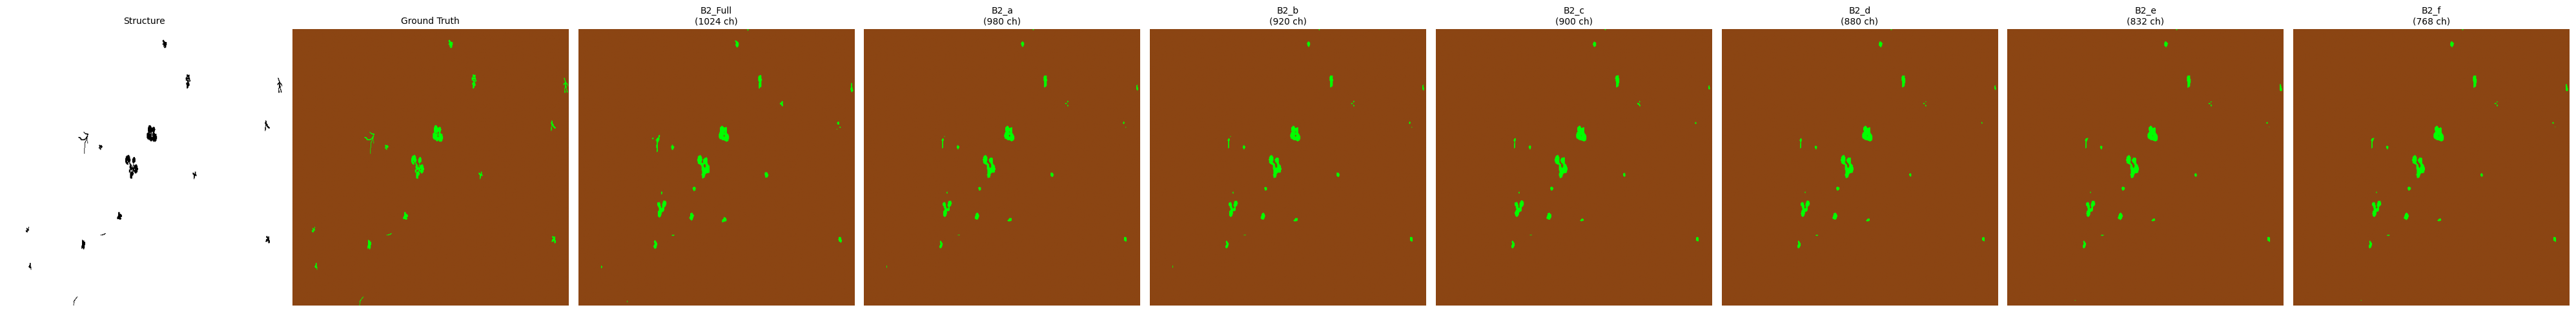

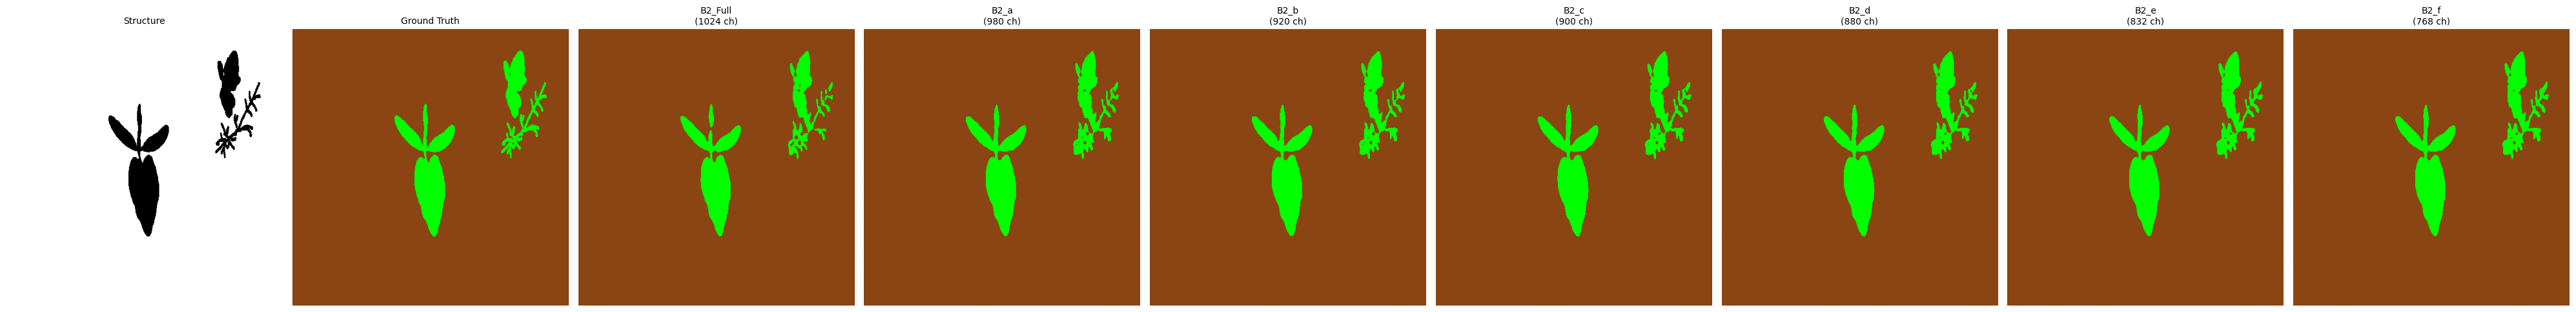

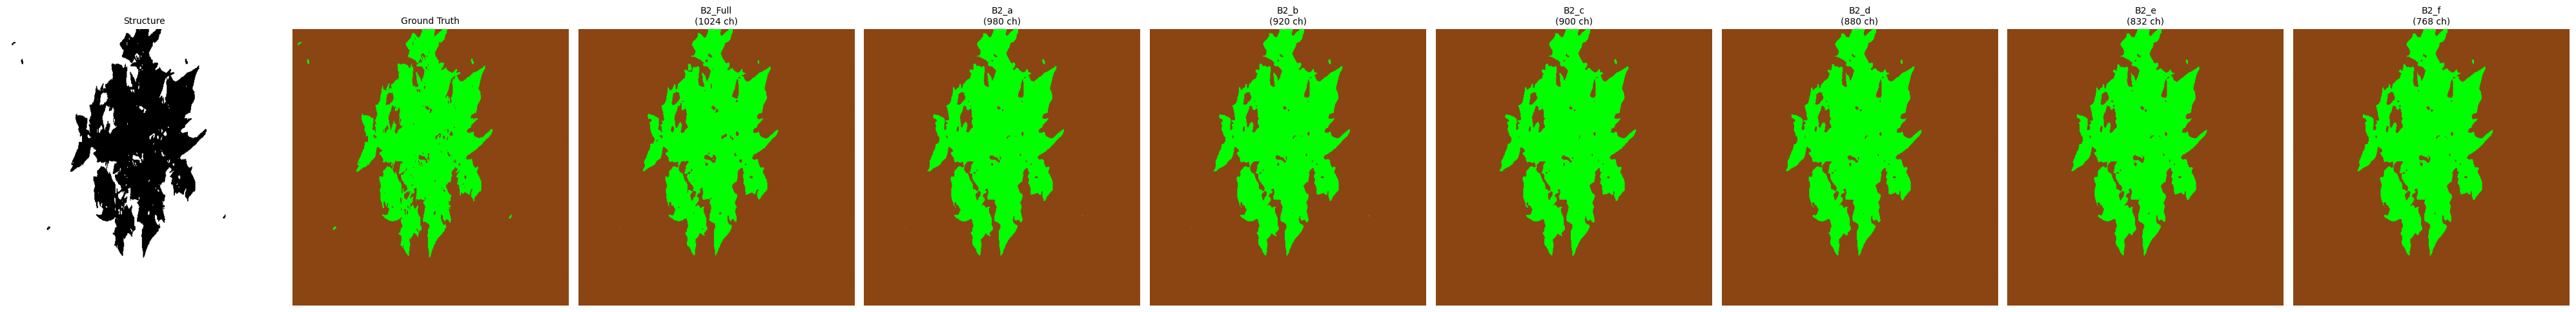

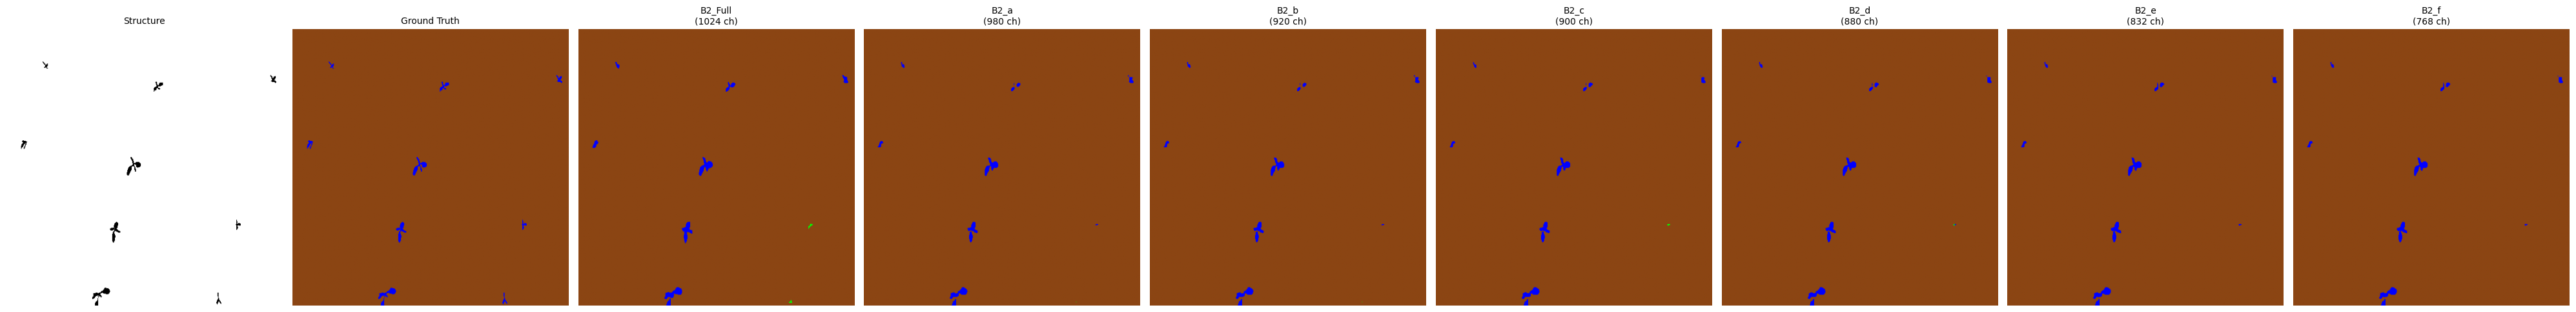

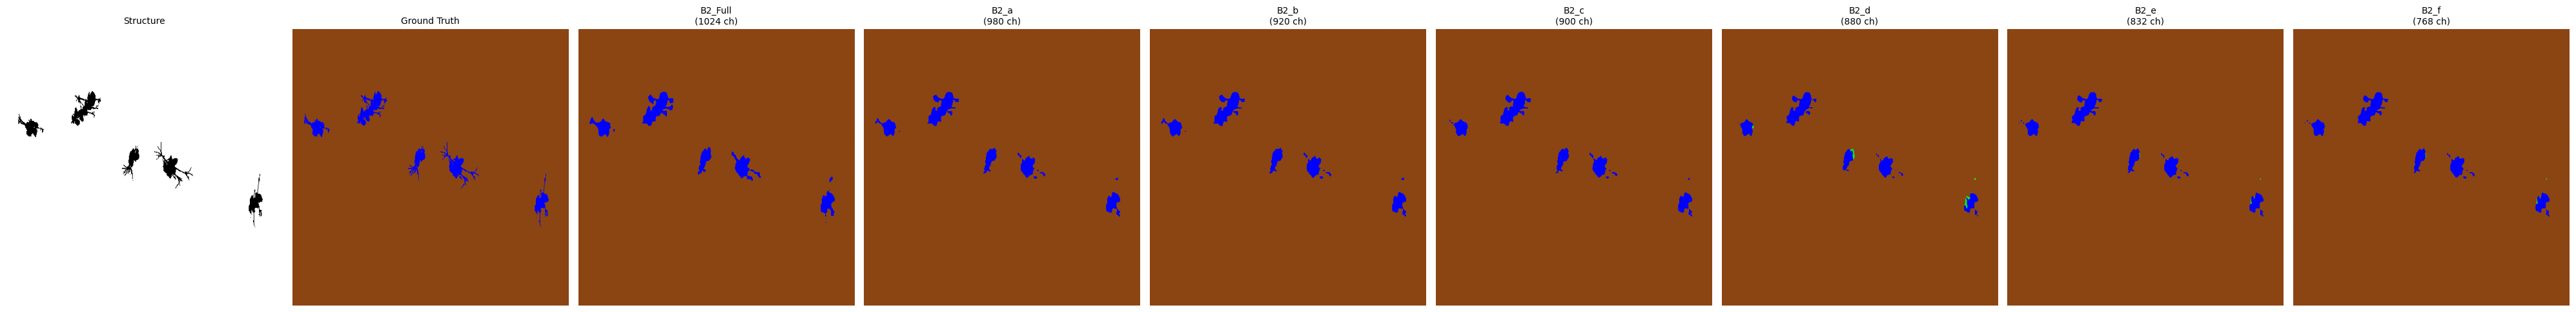

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# --- 1. DEFINE ALL CONFIGS ---
# We define the full spectrum of trade-offs
FULL_MASK = [0]*16

ALL_RDD_CONFIGS_NEW = {
    "B2_Full": {"mask": FULL_MASK, "channels": 1024},
    "B2_a":    {"mask": [0,0,1] + [0]*13, "channels": 980},
    "B2_b":    {"mask": [0,0,1] + [0]*13, "channels": 920},
    "B2_c":    {"mask": [0,0,1] + [0,0,0,1] + [0]*9, "channels": 900},
    "B2_d":    {"mask": [0,0,1] + [0,0,0,1] + [0,0,0,0,0,1] + [0]*3, "channels": 880},
    "B2_e":    {"mask": [0,0,1] + [0,0,0,1] + [0,0,0,0,0,1] + [0,0,1], "channels": 832},
    "B2_f":    {"mask": [0,0,1] + [0,0,0,1] + [0,0,0,0,0,1] + [0,0,1], "channels": 768}
}

# --- 2. HELPER: APPLY MODE ---
def set_rdd_mode(model, wrappers, config_data):
    for i, skip_val in enumerate(config_data["mask"]):
        wrappers[i].skip = bool(skip_val)
    model.custom_decoder.linear_fuse.active_in_channels = config_data["channels"]

# --- 3. HELPER: BATCH PREDICTION ---
def predict_batch(model, pixel_values, target_shape):
    with torch.no_grad():
        out = model(pixel_values)
        if isinstance(out, tuple): out = out[1]

        if out.shape[-2:] != target_shape[-2:]:
            out = torch.nn.functional.interpolate(
                out, size=target_shape[-2:], mode='bilinear', align_corners=False
            )
    return out.argmax(dim=1).cpu().numpy()

# --- 4. MAIN VISUALIZATION FUNCTION ---
def visualize_all_configs(model, wrappers, dataloader, num_samples=2):
    model.eval()

    # A. Get Data
    temp_loader = DataLoader(dataloader.dataset, batch_size=num_samples, shuffle=True)
    batch = next(iter(temp_loader))
    pixel_values = batch["pixel_values"].to(device)
    labels = batch["labels"].cpu().numpy()

    print(f"\n--- Comparing ALL RDD Configs on {num_samples} Samples ---")

    # B. Collect Predictions for EVERY Config
    # We store them in a dictionary: { "B2_Full": [pred1, pred2...], "B2_a": ... }
    all_preds = {}

    for name, cfg in ALL_RDD_CONFIGS_NEW.items():
        print(f" > Running Inference for {name}...")
        set_rdd_mode(model, wrappers, cfg)
        all_preds[name] = predict_batch(model, pixel_values, batch["labels"].shape)

    # C. Define Colors
    colors = np.array([
        [0, 0, 255],    # Crop (Blue)
        [0, 255, 0],    # Weed (Green)
        [139, 69, 19]   # Soil (Brown)
    ]) / 255.0

    # D. Plotting
    # We need 2 baseline columns + 7 config columns = 9 columns total
    num_cols = 2 + len(ALL_RDD_CONFIGS_NEW)

    for i in range(num_samples):
        # Create a very wide figure
        fig, axes = plt.subplots(1, num_cols, figsize=(40, 5))

        # Col 0: Structure
        axes[0].imshow(labels[i], cmap='gray')
        axes[0].set_title("Structure", fontsize=10)
        axes[0].axis('off')

        # Col 1: Ground Truth
        axes[1].imshow(colors[labels[i] % 3])
        axes[1].set_title("Ground Truth", fontsize=10)
        axes[1].axis('off')

        # Col 2-8: The Configs
        config_names = list(ALL_RDD_CONFIGS_NEW.keys())
        for idx, name in enumerate(config_names):
            col_idx = idx + 2
            pred_mask = all_preds[name][i]

            axes[col_idx].imshow(colors[pred_mask])
            axes[col_idx].set_title(f"{name}\n({ALL_RDD_CONFIGS_NEW[name]['channels']} ch)", fontsize=10)
            axes[col_idx].axis('off')

        plt.tight_layout()
        plt.show()

# --- EXECUTE ---
# Note: This might take 10-20 seconds to render due to multiple passes
visualize_all_configs(model_v2, encoder_wrappers, val_dataloader, num_samples=5)


--- Comparing ALL RDD Configs on 5 Samples ---
 > Running Inference for B2_Full...
 > Running Inference for B2_a...
 > Running Inference for B2_b...
 > Running Inference for B2_c...
 > Running Inference for B2_d...
 > Running Inference for B2_e...
 > Running Inference for B2_f...


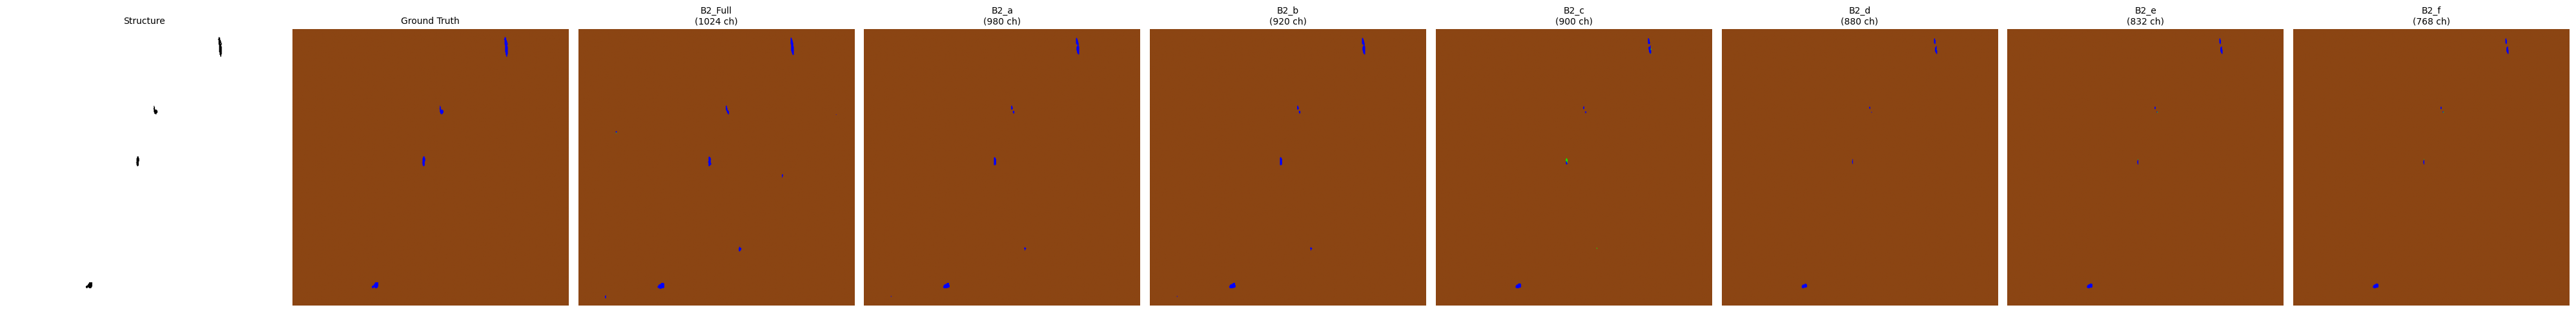

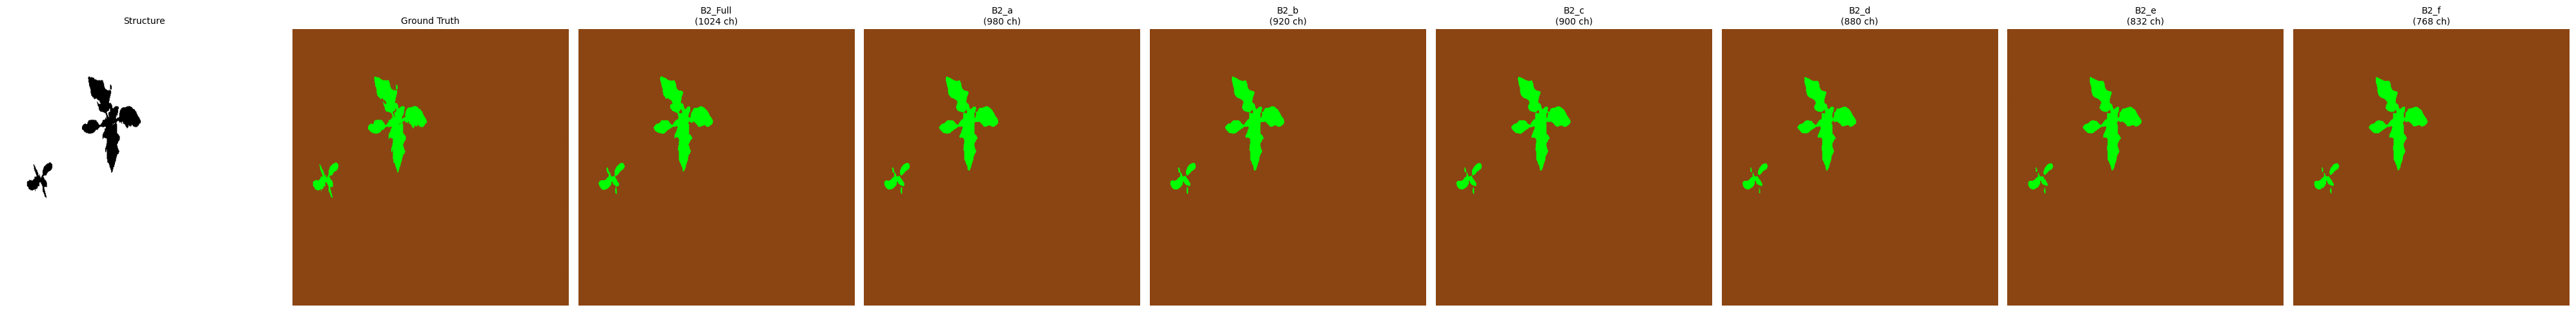

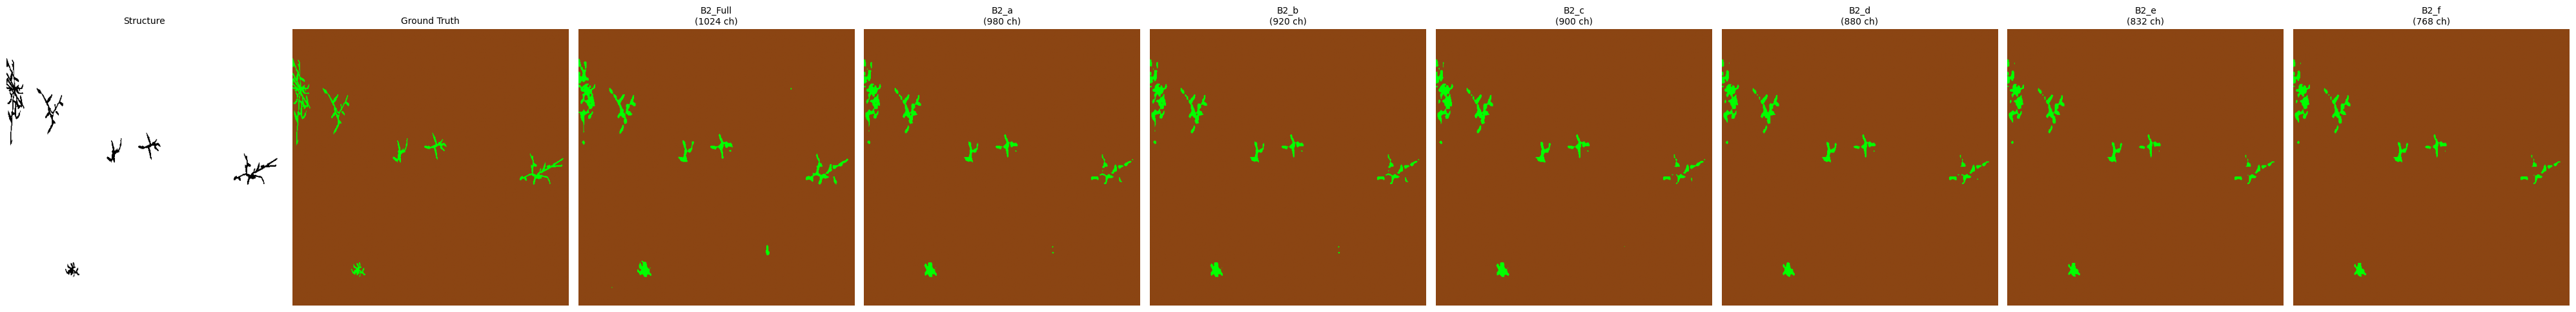

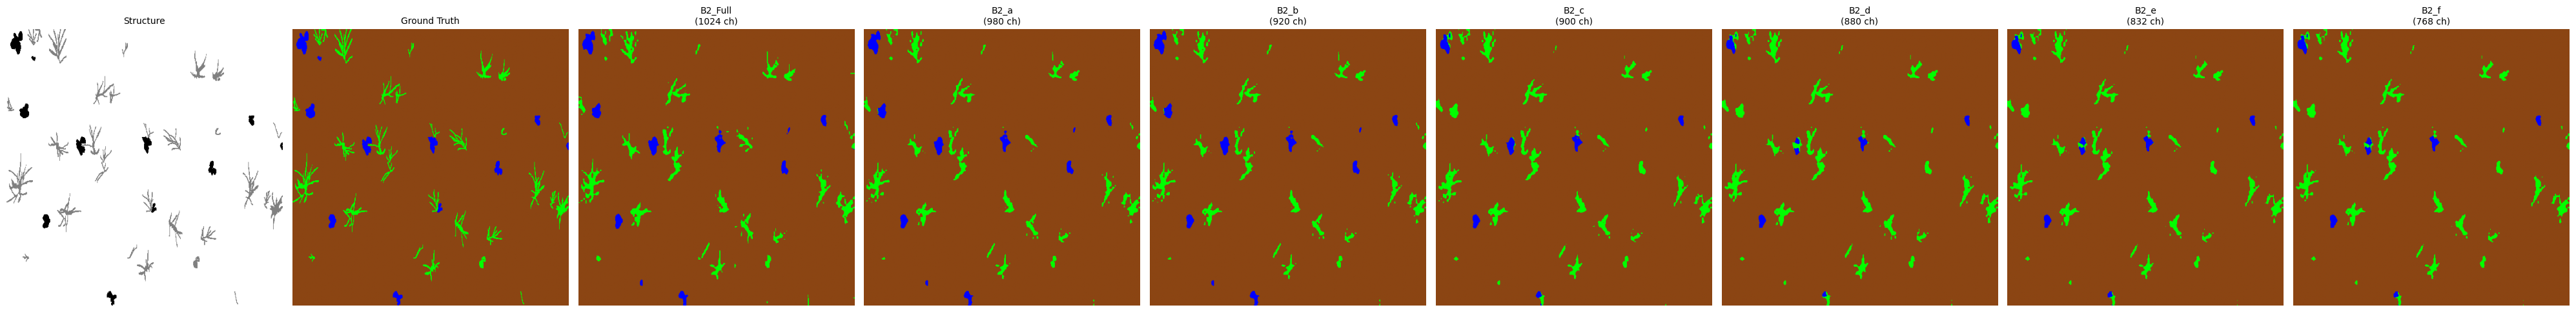

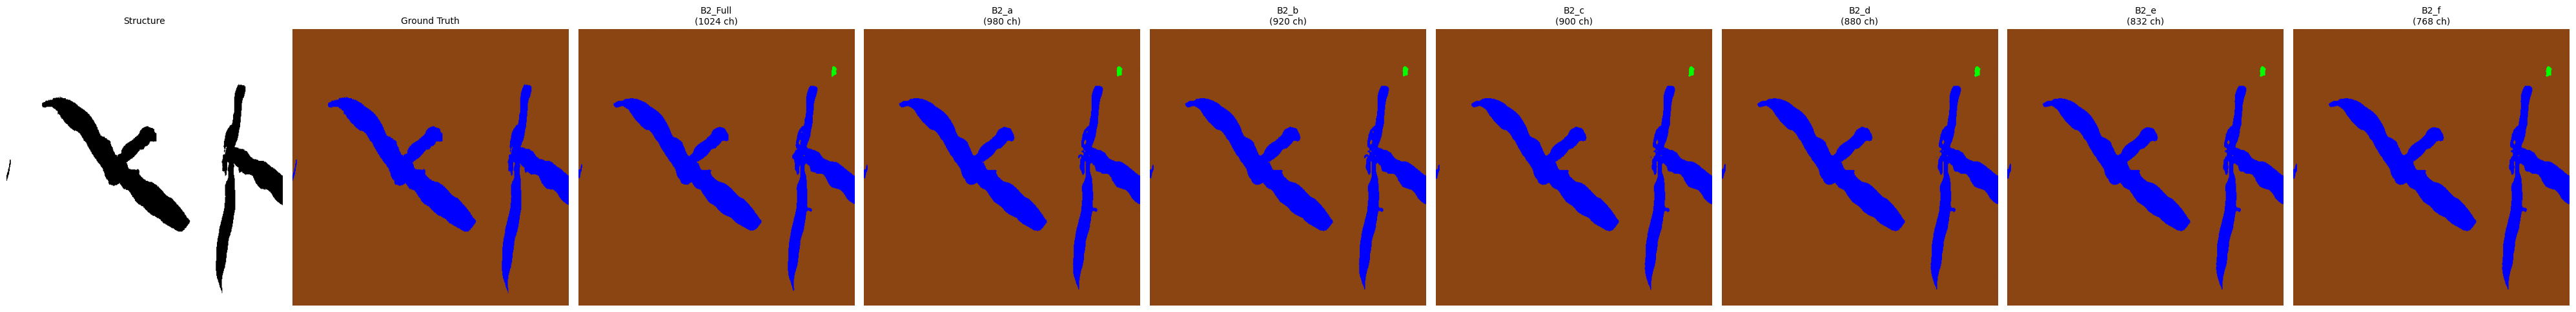

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# --- 1. DEFINE ALL CONFIGS ---
# We define the full spectrum of trade-offs
FULL_MASK = [0]*16

ALL_RDD_CONFIGS_NEW = {
    "B2_Full": {"mask": FULL_MASK, "channels": 1024},
    "B2_a":    {"mask": [0,0,1] + [0]*13, "channels": 980},
    "B2_b":    {"mask": [0,0,1] + [0]*13, "channels": 920},
    "B2_c":    {"mask": [0,0,1] + [0,0,0,1] + [0]*9, "channels": 900},
    "B2_d":    {"mask": [0,0,1] + [0,0,0,1] + [0,0,0,0,0,1] + [0]*3, "channels": 880},
    "B2_e":    {"mask": [0,0,1] + [0,0,0,1] + [0,0,0,0,0,1] + [0,0,1], "channels": 832},
    "B2_f":    {"mask": [0,0,1] + [0,0,0,1] + [0,0,0,0,0,1] + [0,0,1], "channels": 768}
}

# --- 2. HELPER: APPLY MODE ---
def set_rdd_mode(model, wrappers, config_data):
    for i, skip_val in enumerate(config_data["mask"]):
        wrappers[i].skip = bool(skip_val)
    model.custom_decoder.linear_fuse.active_in_channels = config_data["channels"]

# --- 3. HELPER: BATCH PREDICTION ---
def predict_batch(model, pixel_values, target_shape):
    with torch.no_grad():
        out = model(pixel_values)
        if isinstance(out, tuple): out = out[1]

        if out.shape[-2:] != target_shape[-2:]:
            out = torch.nn.functional.interpolate(
                out, size=target_shape[-2:], mode='bilinear', align_corners=False
            )
    return out.argmax(dim=1).cpu().numpy()

# --- 4. MAIN VISUALIZATION FUNCTION ---
def visualize_all_configs(model, wrappers, dataloader, num_samples=2):
    model.eval()

    # A. Get Data
    temp_loader = DataLoader(dataloader.dataset, batch_size=num_samples, shuffle=True)
    batch = next(iter(temp_loader))
    pixel_values = batch["pixel_values"].to(device)
    labels = batch["labels"].cpu().numpy()

    print(f"\n--- Comparing ALL RDD Configs on {num_samples} Samples ---")

    # B. Collect Predictions for EVERY Config
    # We store them in a dictionary: { "B2_Full": [pred1, pred2...], "B2_a": ... }
    all_preds = {}

    for name, cfg in ALL_RDD_CONFIGS_NEW.items():
        print(f" > Running Inference for {name}...")
        set_rdd_mode(model, wrappers, cfg)
        all_preds[name] = predict_batch(model, pixel_values, batch["labels"].shape)

    # C. Define Colors
    colors = np.array([
        [0, 0, 255],    # Crop (Blue)
        [0, 255, 0],    # Weed (Green)
        [139, 69, 19]   # Soil (Brown)
    ]) / 255.0

    # D. Plotting
    # We need 2 baseline columns + 7 config columns = 9 columns total
    num_cols = 2 + len(ALL_RDD_CONFIGS_NEW)

    for i in range(num_samples):
        # Create a very wide figure
        fig, axes = plt.subplots(1, num_cols, figsize=(40, 5))

        # Col 0: Structure
        axes[0].imshow(labels[i], cmap='gray')
        axes[0].set_title("Structure", fontsize=10)
        axes[0].axis('off')

        # Col 1: Ground Truth
        axes[1].imshow(colors[labels[i] % 3])
        axes[1].set_title("Ground Truth", fontsize=10)
        axes[1].axis('off')

        # Col 2-8: The Configs
        config_names = list(ALL_RDD_CONFIGS_NEW.keys())
        for idx, name in enumerate(config_names):
            col_idx = idx + 2
            pred_mask = all_preds[name][i]

            axes[col_idx].imshow(colors[pred_mask])
            axes[col_idx].set_title(f"{name}\n({ALL_RDD_CONFIGS_NEW[name]['channels']} ch)", fontsize=10)
            axes[col_idx].axis('off')

        plt.tight_layout()
        plt.show()

# --- EXECUTE ---
# Note: This might take 10-20 seconds to render due to multiple passes
visualize_all_configs(model_v2, encoder_wrappers, val_dataloader, num_samples=5)


--- Comparing ALL RDD Configs on 5 Samples ---
 > Running Inference for B2_Full...
 > Running Inference for B2_a...
 > Running Inference for B2_b...
 > Running Inference for B2_c...
 > Running Inference for B2_d...
 > Running Inference for B2_e...
 > Running Inference for B2_f...


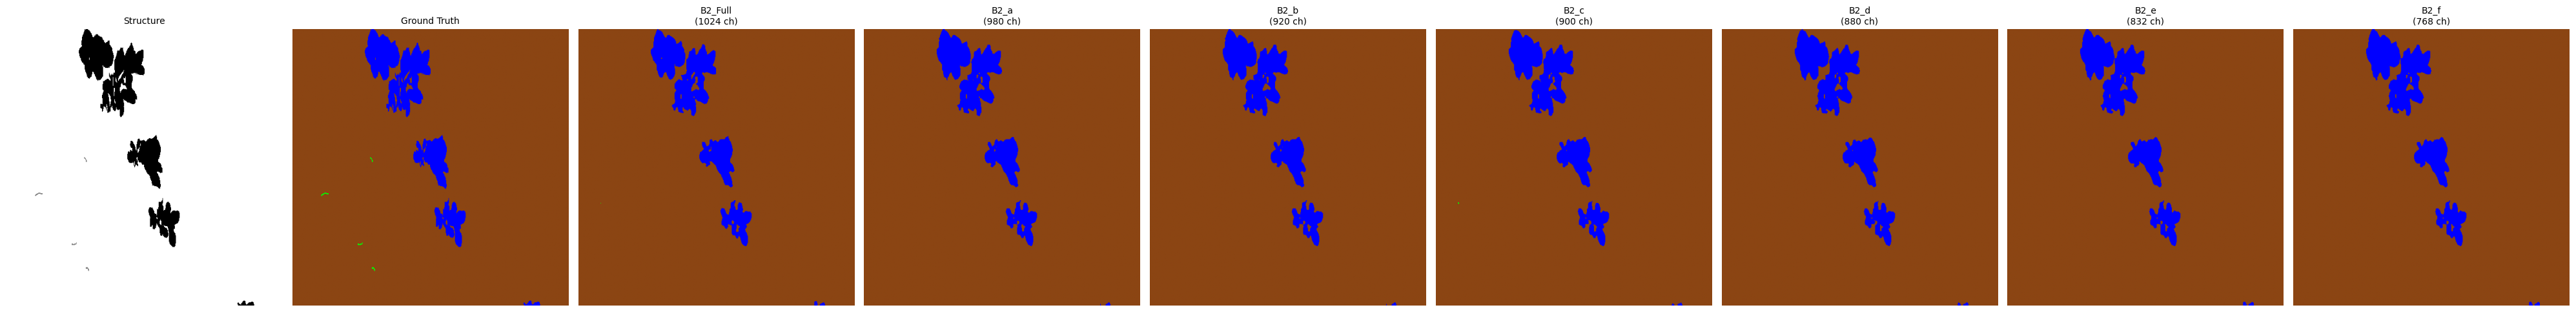

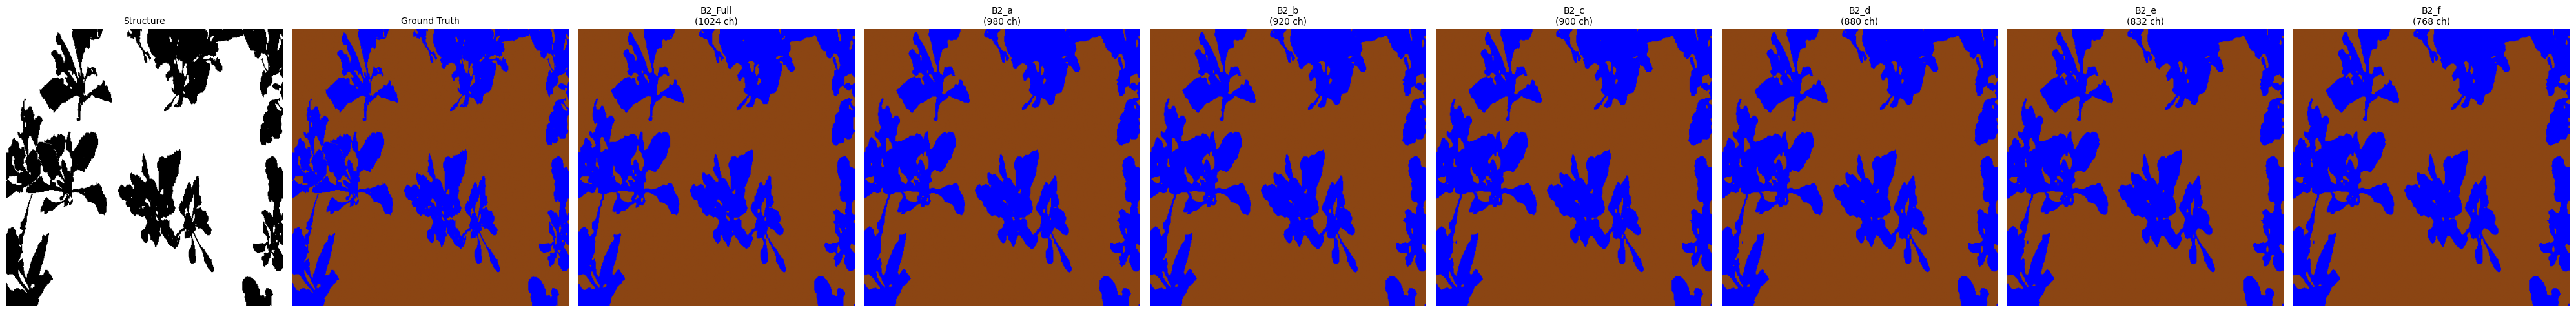

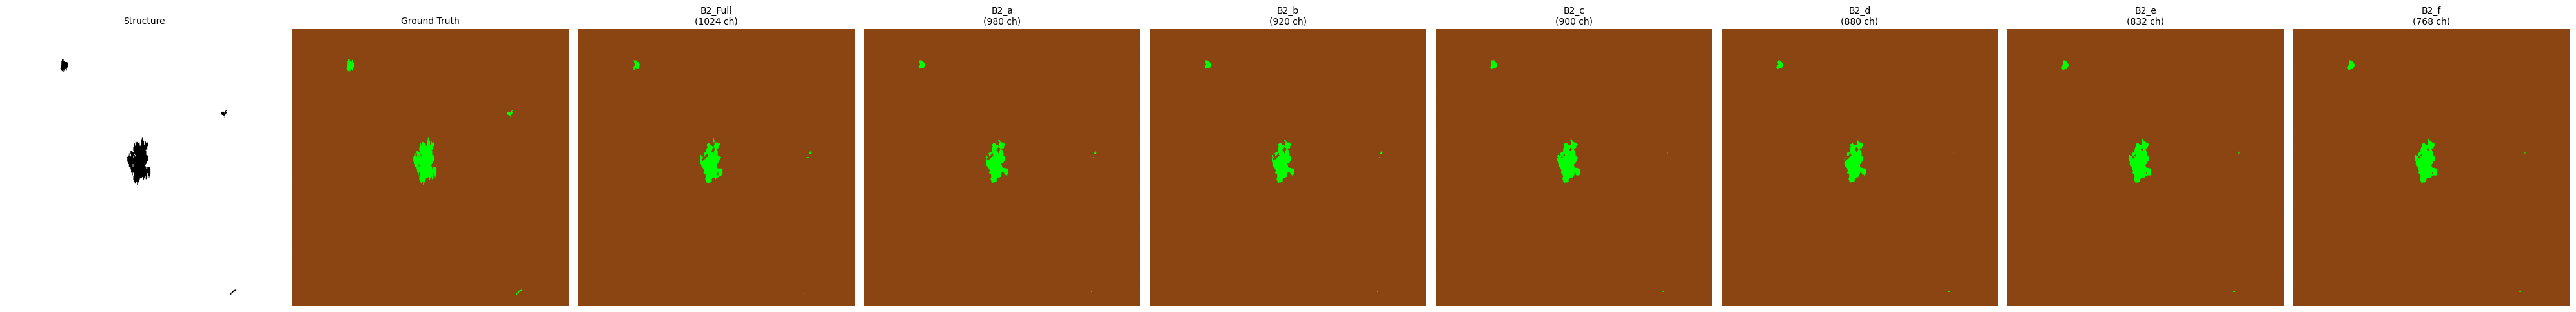

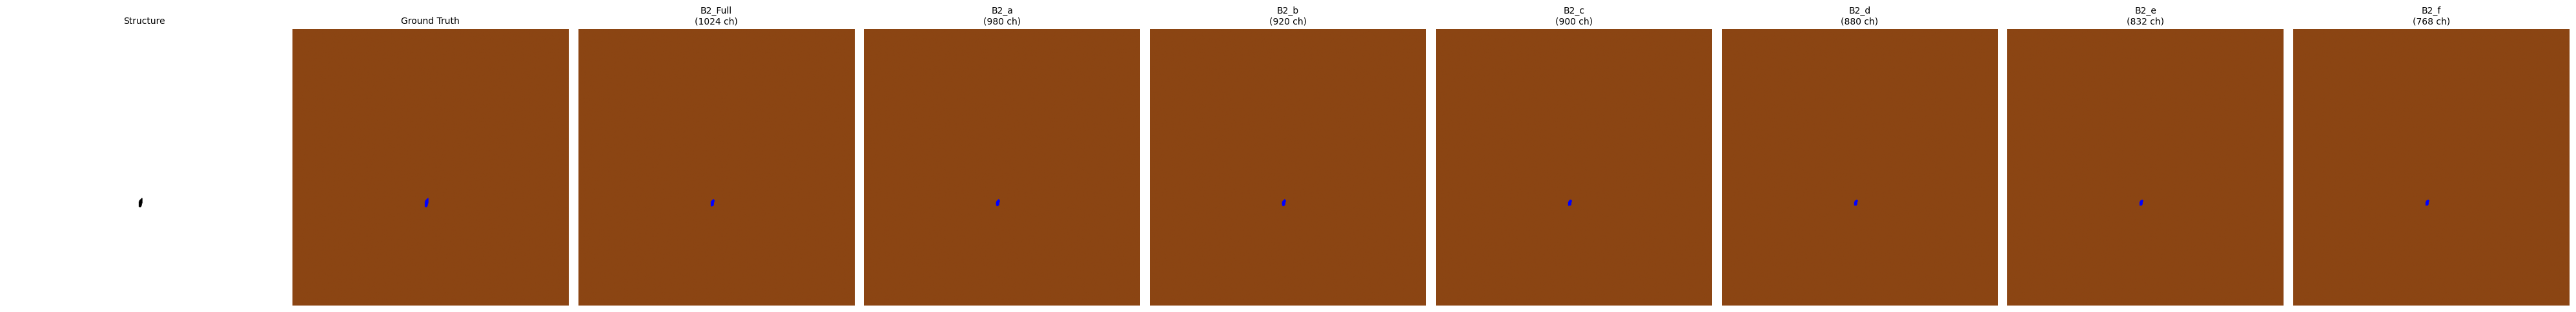

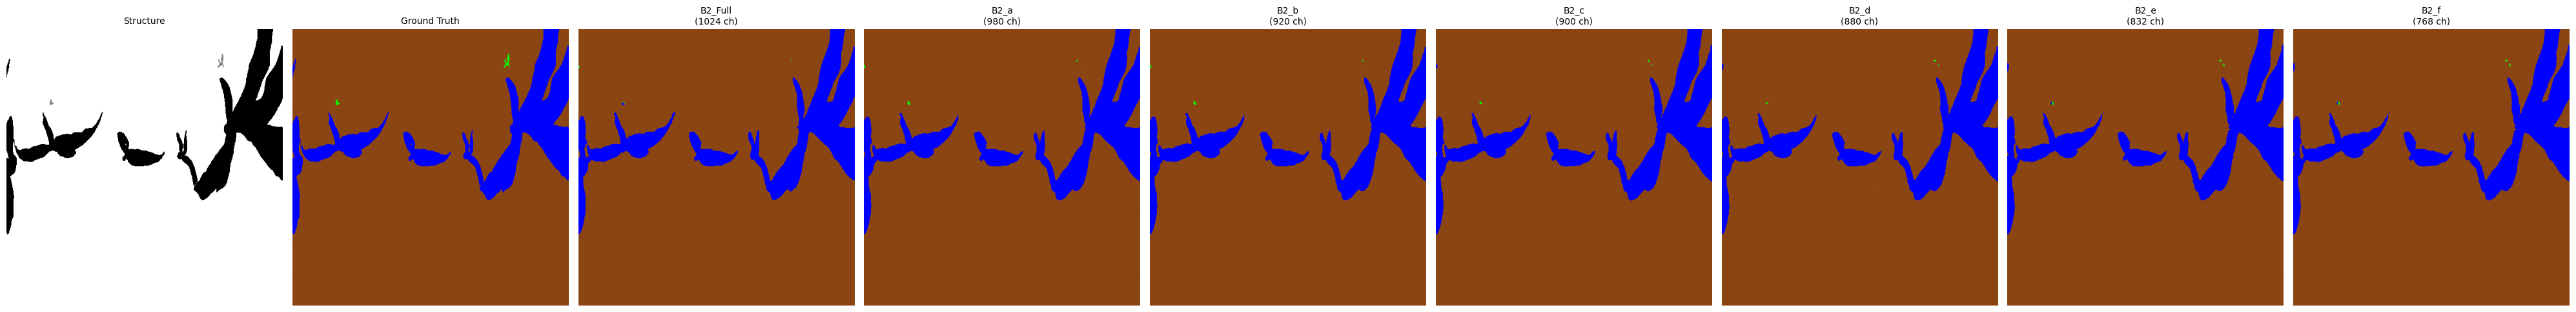

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# --- 1. DEFINE ALL CONFIGS ---
# We define the full spectrum of trade-offs
FULL_MASK = [0]*16

ALL_RDD_CONFIGS_NEW = {
    "B2_Full": {"mask": FULL_MASK, "channels": 1024},
    "B2_a":    {"mask": [0,0,1] + [0]*13, "channels": 980},
    "B2_b":    {"mask": [0,0,1] + [0]*13, "channels": 920},
    "B2_c":    {"mask": [0,0,1] + [0,0,0,1] + [0]*9, "channels": 900},
    "B2_d":    {"mask": [0,0,1] + [0,0,0,1] + [0,0,0,0,0,1] + [0]*3, "channels": 880},
    "B2_e":    {"mask": [0,0,1] + [0,0,0,1] + [0,0,0,0,0,1] + [0,0,1], "channels": 832},
    "B2_f":    {"mask": [0,0,1] + [0,0,0,1] + [0,0,0,0,0,1] + [0,0,1], "channels": 768}
}

# --- 2. HELPER: APPLY MODE ---
def set_rdd_mode(model, wrappers, config_data):
    for i, skip_val in enumerate(config_data["mask"]):
        wrappers[i].skip = bool(skip_val)
    model.custom_decoder.linear_fuse.active_in_channels = config_data["channels"]

# --- 3. HELPER: BATCH PREDICTION ---
def predict_batch(model, pixel_values, target_shape):
    with torch.no_grad():
        out = model(pixel_values)
        if isinstance(out, tuple): out = out[1]

        if out.shape[-2:] != target_shape[-2:]:
            out = torch.nn.functional.interpolate(
                out, size=target_shape[-2:], mode='bilinear', align_corners=False
            )
    return out.argmax(dim=1).cpu().numpy()

# --- 4. MAIN VISUALIZATION FUNCTION ---
def visualize_all_configs(model, wrappers, dataloader, num_samples=2):
    model.eval()

    # A. Get Data
    temp_loader = DataLoader(dataloader.dataset, batch_size=num_samples, shuffle=True)
    batch = next(iter(temp_loader))
    pixel_values = batch["pixel_values"].to(device)
    labels = batch["labels"].cpu().numpy()

    print(f"\n--- Comparing ALL RDD Configs on {num_samples} Samples ---")

    # B. Collect Predictions for EVERY Config
    # We store them in a dictionary: { "B2_Full": [pred1, pred2...], "B2_a": ... }
    all_preds = {}

    for name, cfg in ALL_RDD_CONFIGS_NEW.items():
        print(f" > Running Inference for {name}...")
        set_rdd_mode(model, wrappers, cfg)
        all_preds[name] = predict_batch(model, pixel_values, batch["labels"].shape)

    # C. Define Colors
    colors = np.array([
        [0, 0, 255],    # Crop (Blue)
        [0, 255, 0],    # Weed (Green)
        [139, 69, 19]   # Soil (Brown)
    ]) / 255.0

    # D. Plotting
    # We need 2 baseline columns + 7 config columns = 9 columns total
    num_cols = 2 + len(ALL_RDD_CONFIGS_NEW)

    for i in range(num_samples):
        # Create a very wide figure
        fig, axes = plt.subplots(1, num_cols, figsize=(40, 5))

        # Col 0: Structure
        axes[0].imshow(labels[i], cmap='gray')
        axes[0].set_title("Structure", fontsize=10)
        axes[0].axis('off')

        # Col 1: Ground Truth
        axes[1].imshow(colors[labels[i] % 3])
        axes[1].set_title("Ground Truth", fontsize=10)
        axes[1].axis('off')

        # Col 2-8: The Configs
        config_names = list(ALL_RDD_CONFIGS_NEW.keys())
        for idx, name in enumerate(config_names):
            col_idx = idx + 2
            pred_mask = all_preds[name][i]

            axes[col_idx].imshow(colors[pred_mask])
            axes[col_idx].set_title(f"{name}\n({ALL_RDD_CONFIGS_NEW[name]['channels']} ch)", fontsize=10)
            axes[col_idx].axis('off')

        plt.tight_layout()
        plt.show()

# --- EXECUTE ---
# Note: This might take 10-20 seconds to render due to multiple passes
visualize_all_configs(model_v2, encoder_wrappers, val_dataloader, num_samples=5)

In [ ]:
import torch
try:
    import fvcore
except ImportError:
    print("Installing fvcore...")
    !pip install -q fvcore
from fvcore.nn import FlopCountAnalysis

# --- 1. The NEW RDD Knowledge Base ---
# Updated with your "Final Paper Reproduction" metrics
RDD_LOOKUP_TABLE_TRY = [
    # 1. B2_Full: Baseline (High Latency)
    # FPS: 5.6 -> Latency: ~178.6 ms
    {"name": "B2_Full", "miou": 0.8908, "fps": 5.6, "latency_ms": 178.6, "gflops": 0.0},

    # 2. B2_a: Optimized Baseline (Huge Speed Jump)
    # FPS: 8.9 -> Latency: ~112.4 ms
    {"name": "B2_a",    "miou": 0.8819, "fps": 8.9, "latency_ms": 112.4, "gflops": 0.0},

    # 3. B2_b: Balanced Speed/Acc
    # FPS: 9.3 -> Latency: ~107.5 ms
    {"name": "B2_b",    "miou": 0.8819, "fps": 9.2, "latency_ms": 108.7, "gflops": 0.0},

    # 4. B2_c: Efficiency Drop starts here (mIoU drops to 86%)
    # FPS: 9.2 -> Latency: ~108.7 ms
    {"name": "B2_c",    "miou": 0.8635, "fps": 9.3, "latency_ms": 107.5, "gflops": 0.0},

    # 5. B2_d: Aggressive Optimization
    # FPS: 9.3 -> Latency: ~107.5 ms
    {"name": "B2_d",    "miou": 0.8555, "fps": 9.4, "latency_ms": 106.3, "gflops": 0.0},

    # 6. B2_e: "Super Eco" Test (12/16 Blocks)
    # FPS: 9.0 -> Latency: ~111.1 ms
    {"name": "B2_e",    "miou": 0.8557, "fps": 9.5, "latency_ms": 105.2, "gflops": 0.0},

    # 7. B2_f: "Super Eco" Floor
    # FPS: 9.2 -> Latency: ~108.7 ms
    {"name": "B2_f",    "miou": 0.8557, "fps": 9.6, "latency_ms": 104.1, "gflops": 0.0},
]

# --- 2. Profiling Function ---
def profile_flops(model, wrappers_list, config_name):
    # Apply the specific RDD configuration
    apply_rdd_config(model, wrappers_list, config_name)

    # Move to CPU for accurate arithmetic counting
    model.cpu()
    model.eval()

    # Dummy Input (Standard batch size 1)
    dummy_input = torch.randn(1, 3, 512, 512)

    # Run Profiler
    flops = FlopCountAnalysis(model, dummy_input)
    flops.unsupported_ops_warnings(False)
    flops.uncalled_modules_warnings(False)

    # Calculate GFLOPs
    gflops = flops.total() / 1e9
    print(f"Config: {config_name:<10} | GFLOPs: {gflops:.2f}")

    # Move back to GPU for future use
    model.to(device)
    return gflops

# --- 3. Execute ---
print("\n" + "="*40)
print("PROFILING ENERGY COST (GFLOPs)")
print("="*40)

for entry in RDD_LOOKUP_TABLE_TRY:
    # Profile and update the table in-place
    entry['gflops'] = profile_flops(model_v2, encoder_wrappers, entry['name'])

print("-" * 40)
print("Updated Knowledge Base with Real Measured FLOPs.")